<a class="anchor" id="nutshell"></a>
<h2 style="font-family:'Verdana',sans-serif; color:#1D7874;">4. Reward and Score of an agent </h2>



## Goal of this notebook
This notebook will describe the score of the competition to rank the participants and finally conlude by explaining the structure an agent should have.


# 1 - Loading the environment

The first time that you build the environment, grid2op will automatically download all the corresponding data (about 4-5Go for the smallest dataset).

We will first create an agent and (re) explain some of the basics of grid2op.

Import the required libraries :

In [3]:
import sys
import logging
import os
#%matplotlib inline
# Uncomment the next lines to auto-reload libraries (this causes some problem with pickles in Python 3)
%load_ext autoreload
%autoreload 2
#import seaborn as sns; sns.set()
import warnings
import numpy as np
import pandas as pd
# import evaluate
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import subprocess
import json
import datetime 
import zipfile
from grid2op import make
import os
warnings.simplefilter(action='ignore', category=FutureWarning)
from utils import problem_dir, score_dir, input_data_check_dir, output_dir

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's define a path for our submission.

In this file we use the standard submission in the "example_submissions" make sure to have a look at them. They all explain how to make a submission :-)

In [4]:
model_dir = 'example_submissions/submission'

if not os.path.exists(model_dir):
    os.makedirs(model_dir)

Note that the zipped file that you will upload to Codalab can be named how you want, but **the submission folder (for this notebook) absolutely must be named "submission", as we did here.**

In [5]:

env = make("l2rpn_icaps_2021_small",difficulty="competition")


/home/horacio/.local/lib/python3.6/site-packages/grid2op/MakeEnv/Make.py:330: UserWarning: It is the first time you use the environment "l2rpn_icaps_2021_small".
We will attempt to download this environment from remote
  warnings.warn(_MAKE_FIRST_TIME_WARN.format(dataset_name))
l2rpn_icaps_2021_small.tar.bz2: 0.00B [00:00, ?B/s]

downloading the training data, this may take a while.


l2rpn_icaps_2021_small.tar.bz2: 1.04GB [04:28, 3.88MB/s]                            


Extract the tar archive in "/home/horacio/data_grid2op"
You may now use the environment "l2rpn_icaps_2021_small" with the available data by invoking:
	env = grid2op.make("l2rpn_icaps_2021_small")


# 2 - Action Space
Actions can consist of:
- reconnecting/disconnecting a powerline
- changing the topology of the grid (choose to isolate some objects [productions, loads, powerlines] from other
- modify the production set point with redispatching actions
- renewable production curtailments (not the thermal production) under certain conditions especially given physical laws (you have to meet load demand with active production ramps and capacities)

These parameters are accessible through the "Parameters" class of grid2op. During training, you can modify some of these parameters to relax some constraints and initialize your training better.

At each step one can do,
- an action on a single substation
and
- an action on a single powerline status
and
- redispatching action on as many generators as you want
and
- curtailment action on renewables production


Be aware that some actions can be considered illegal by grid2op if they don't comply with some conditions. In that case, no action will be taken at that timestep, similar to a do-nothing.

For more detailed on action space understanding, please check the notebook: https://github.com/rte-france/Grid2Op/blob/master/getting_started/03_Action.ipynb and documentation: https://grid2op.readthedocs.io/en/latest/action.html.

# 3 - The Reward and the Score of an agent

### Reward
The Reward is the quantity that your agent will aim to maximize during training or calibration. This is a rather personal choice, you can choose any reward function that you think is adequate.

Grid2op allows for a large variety of such reward functions. You can visit [rewards in grid2op](https://grid2op.readthedocs.io/en/latest/reward.html) for more information about rewards.

In this competition, you can use any of the provided reward functions, or your own, to train your agent and to assess its performance. To do that, you need to have the reward class that you want to use as a `reward` variable in your `__init__.py`. That class must be a subclass of `grid2op.Reward.BaseReward.BaseReward`. See the official help for the competition on our discord https://discord.gg/cYsYrPT if you need some help. 

More examples will be provided for the complete competition.

### Overall Score
The Score is the quantity that is used to compare your agent with the agents of the other participants.
For ICAPS competition, the total score is a weighted sum of two scores: the grid operation cost score $\mathcal{Score}_{OperationCost}$ and the attention score $\mathcal{Score}_{Attention}$:

\begin{equation}
    \mathcal{Score}=0.3*{Score}_{Attention}+0.7*{Score}_{OperationCost}
\end{equation}

Notice the different weights. More weight is still given for proper grid operation management. Yet a good amount of points are also given for sending proper alerts while managing the attention of the operator. It can even make you lose more points if not done properlY.

#### Episodes
Each score is more specifically computed over a set of episodes.

Formally, we can define an "episode" $e$ successfully managed by an agent up to a time $t_{\text{end}}$ (on a scenario of maximum length $T_e$) by:
\begin{equation}
e = \left(o_1, a_1, o_2, a_2,\dots, a_{t_{\text{end}}-1}, o_{t_{\text{end}} }\right)
\end{equation}
where $o_t$ represents the observation at time $t$, and $a_t$ the action that the agent took at time t. In particular, $o_1$ is the first observation and $o_{t_{\text{end}}}$ is the last one. The scenario ended at time $t_{end}$, either because there was a game over or because the agent reached the end of the scenario.

The participants will indeed be tested on $N$ hidden weekly scenarios at 5-min resolution, and on various situations that proved difficult to our baselines. This will be the way to test the agent's behavior in various representative conditions. The overall score to minimize over all the scenarios given a cost function c per episode will be :

\begin{equation}
{Score}_{xxx}=\sum\limits_{i=1}^{N}c(e_i)
\end{equation}

#### Score for Attention

Your score of attention will range in between -200 and 100 per episode. We will distinguish case of sucess and failure for a given scenario. We will further discriminate between failures due to overflow disconnections and others. 
Beside case of failure due to overflow disconnection, the score is simple, either 100 or -200.
Otherwise, the attention score will be based on alarm sent by the agent before failure. It is composed of two parts: points will be given base on the time of the alarm, and additional points will be given for pointing our to a releavnt zone on the grid where the failure is occuring.

<ins>In case you finish a scenario:</ins>

You will automatically get the **100 points**,  the maximum number of points for it. We still encourage you strongly to manage the scenario as long as possible.

<ins>In case of failure:</ins>

If the failure is not due to overflow disconnections leading to a cascading failure, this will be considered as an intentional mistake and you will get penalized with a score of -200, as if you did not send an alarm. This can happen if you disconnect a load yourself or get an unfeasible state (=a power flow simulation divergence) 



Now when the failure is due to overflow disconnections:

**Timely alarm:** Points are given for attention if an alarm was sent prior to failure in a proper time window ahead of time. You alarm should ideally be send at $t_{ideal-alarm}$=7 (35 minutes) before failure at $t_{end}$. This would be an appropriate time in real life for an operator to take over, make an advanced study and take a better decision. In that case you will get **66.7 points**.  Within an alarm window of size $window\_size$ around $t_{ideal-alarm}$ your alarm will still be considered successful and give you some points. However, if no successful alarm is sent, a penalty of **-200 points** is assigned. Be mindful that alarms cannot be send at all times: you only have available a small budget of alarm that you should use carefully.

For a given succesful alarm sent at time $t_{alarm}$, its score is:
\begin{equation}
    \mathit{bestTime}=t_{end}-t_{ideal-alarm}
\end{equation}
\begin{equation}
    \mathit{distToBest(alarm)}=abs(bestTime-t_{alarm})
\end{equation}
\begin{equation}
    \mathit{Score}_{timely}(alarm)=-\dfrac{(distToBest(alarm) - window\_size) * (distToBest(alarm) + window\_size)}{ window\_size^2}
\end{equation}



**Spatially localized alarm**: In addition to sending an alarm at the right time, we also encourage you to properly localize the area among 3 ("west","middle","east") where the event is starting. By doing so, you will increase your timely alarm points by 50% (mult_factor=1.5), possibly reaching **100 points** for a given episode. If you refer to the wrong zone, you don't increase your points: mult_factor=1.

\begin{equation}
    \mathcal{Score}_{attention}(alarm)={Score}_{timely}(alarm)*mult\_factor
\end{equation}

For a zone to be considered relevant, one of the lines that started the cascading failure needs to belong to it. Those lines are identified either:
- over a short time window (4 timesteps here) before the gameover if any lines got unintentionally disconnected after overflow
- if none, as the first lines disconnected at the time of gameover 

**Overall attention score in gameover**:
The alarm score for this episode is hence the best score among successful alarms:
\begin{equation}
    \mathcal{Score}_{attention}(e)=max({Score}_{attention}(alarm))
\end{equation}


In [6]:
import numpy as np
t_ideal_alarm=env.parameters.ALARM_BEST_TIME
window_size=env.parameters.ALARM_WINDOW_SIZE #the full window is twice this size from t_ideal_alarm + window_size to t_ideal_alarm - window_size

times=np.array([t for t in range(0,t_ideal_alarm+window_size+2)])
dist_best=abs(times-t_ideal_alarm)
timely_score = -((dist_best - window_size) * (dist_best + window_size)/window_size**2) *67

#not succesful alarm get a score of -200
timely_score[timely_score<=0]=-200

#better score if you get the zone right
score_right_zone=timely_score.copy()
score_right_zone[score_right_zone>0]=timely_score[score_right_zone>0]*1.5


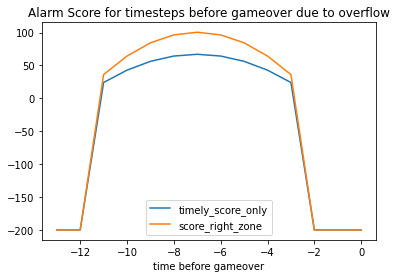

In [7]:
plt.plot(-times,timely_score, label = "timely_score_only")
plt.plot(-times,score_right_zone, label = "score_right_zone")

plt.title('Alarm Score for timesteps before gameover due to overflow')
plt.xlabel('time before gameover')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()


In [8]:
from grid2op.PlotGrid import PlotMatplot


plot_helper = PlotMatplot(env.observation_space, 
                          sub_radius=14, 
                          load_radius=10, 
                          gen_radius=10,
                          width=950,
                          height=600,
                        )

now ploting lines in zone east rendered in yellow
in that case you get the points for pointing to a right zone. Indeed one of the lines in red identified for failure belongs to the zone 
if it would have been the line 15->16 only, you would not have gotten more points


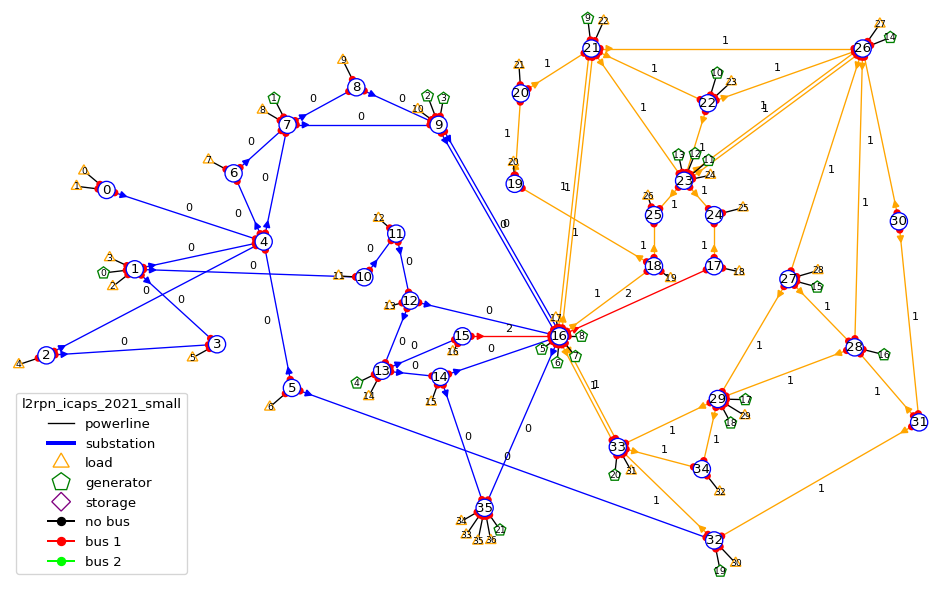

In [9]:
import json
import os

zone="east"
zone_id=env.alarms_area_names.index(zone)

print("now ploting lines in zone "+zone+" rendered in yellow")
lines_east=env.alarms_area_lines[zone_id]
line_vals=[1 if l in lines_east else 0 for l in env.name_line]

line_vals[21]=2
line_vals[22]=2
plot_helper.plot_info(line_values=line_vals,coloring="line")

print("in that case you get the points for pointing to a right zone. Indeed one of the lines in red identified for failure belongs to the zone ")
print("if it would have been the line 15->16 only, you would not have gotten more points")

#### Score for Operation Cost

To begin with, we will recall that transporting electricity always generates some energy losses $\mathcal{E}_{loss}(t)$ due to the Joule effect in resistive powerlines. At any time $t$:
\begin{equation}
    \mathcal{E}_{loss}(t)=\sum\limits_{l=1}^{n_{l}}r_l*{y_l}(t)^2
\end{equation}
Where $r_l$ is the resistance of powerline $l$ and $y_l$ is the current flowing through it.

At any time $t$, the operator of the grid is responsible for compensating those energy losses by purchasing on the energy market the corresponding amount of production at the marginal price $p(t)$. We can therefore define the following energy loss cost $c_{loss}(t)$:

\begin{equation}
c_{loss}(t)=\mathcal{E}_{loss}(t)*p(t)
\end{equation}

Then we should consider that the decisions made by the operator can induce costs, especially when they require market players to perform specific actions, as they should be paid in return. Topological actions (modifying the structure of the grid) are mostly free, since the grid belongs to the powergrid operator, and no energy cost is involved. However, energy producers are affected by the redispatching actions (having some generators produce more energy and others produce less) and should get paid. As the grid operators ask to redispatch some energy $\mathcal{E}_{redispatch}(t)$, some power plants will increase their production by $\mathcal{E}_{redispatch}(t)$ while others will compensate by decreasing their production by the same amount to keep the power grid balanced. Hence, the grid operator will pay both producers for this redispatched energy at an additional cost $c_{redispatching(t)}$, higher than the marginal price $p(t)$ by some factor $\alpha$:

\begin{equation}
c_{redispatching}(t)=2*\mathcal{E}_{redispatch}*\alpha p(t),\ \alpha \geqslant1
\end{equation}

Indeed, the first producer has to be paid an extra $\mathcal{E}_{redispatch}*\alpha p(t)$ because he has to produce $\mathcal{E}_{redispatch}$ more energy than it had planned to, and the second producer also has to be paid an extra $\mathcal{E}_{redispatch}*\alpha p(t)$ to compensate for the $\mathcal{E}_{redispatch}$ energy that it did not produce and sell.

If no flexibility is identified or integrated into the grid, operational costs related to redispatching can dramatically increase due to renewable energy sources (since the production from these energy sources can vary significantly throughout a year) as was the case recently in Germany with **an avoidable 1 billion €/year increase**.

Hence, we can define our overall operational cost $c_{\text{operations}}(t)$:
\begin{equation}
c_{\text{operations}}(t)=c_{\text{loss}}(t)+c_{\text{redispatching}}(t)
\end{equation}


An agent can either manage to operate the grid for the entire scenario ($t_{\text{end}} = T_e$) or fail after some time $t_{\text{end}}$ because of a blackout. In case of a blackout, the cost $c_{\text{blackout}}(t)$ at a given time t would be proportional to the amount of consumption that was not supplied, $\text{Load}(t)$, at a price higher than the marginal price $p(t)$ by some factor $\beta$:
\begin{equation}
c_{\text{blackout}}(t)=\text{Load}(t)*\beta*p(t), \ \beta \geqslant1
\end{equation}
Notice that $\text{Load}(t) >> \mathcal{E}_{\text{redispatch}}(t)$ or $\mathcal{E}_{\text{loss}}(t)$
which means that the cost of a blackout is a lot higher than the cost of operating the grid as expected. It is even higher if we further consider the secondary effects on the economy. More information can be found thanks to <a href="https://www.blackout-simulator.com/">this blackout cost simulator</a>. Furthermore, a blackout does not last forever and power grids restart at some point, but for the sake of simplicity while preserving most of the realism, all these additional complexities are not considered here so the scenario will be terminated in case of a game over.

Now we can define our cost $c$ for an episode:
\begin{equation}
\mathit{Unormalized\_Score}_{OperationCost}(e)=\sum\limits_{t=1}^{t_{\text{end}}} c_{\text{operations}}(t) + \sum\limits_{t=t_{\text{end}}}^{T_{e}}c_{\text{blackout}}(t)
\end{equation}

The participants are encouraged to operate the grid for as long as possible, and will be penalized for a blackout even after the game is over, until $T_e$, as this is a critical system and safety is paramount.





##### Scaling the grid operation score
For the `DoNothing` agent this score was really high on our scenarios, around 33 billions. Since this is less readable, we decided to apply a linear transformation such that:
- the score is 100 for the best possible agent (an agent that handles all the scenarios, without using redispatching actions, with minimal losses of $1%$ for all the scenarios)
- the score is 0 for the `DoNothing` agent

This means that:
- the score should be **maximized** rather than minimized
- having a score of 100 is probably out of reach
- having a positive score is already pretty good and means that your agent is better than the `DoNothing` agent



### But which reward should I use ?
As we said earlier, the reward is a personnal choice. If you have two exact same type of agent (same training scheme, same neural network model, same everything...) and use two different reward it is likely that one will perform better on this competition than the other (though they will be evaluated with the same `score`).

This is common on machine learning. For example, in supervised machine learning you can find similar behaviour even for some problems as common as image classification on [ImageNet](http://www.image-net.org/) for example. Indeed for this competition most neural networks are trained with the [categorical cross entropy loss](https://en.wikipedia.org/wiki/Cross_entropy) while for the "ImageNet competition" (named *Large Scale Visual Recognition Challenge*) the ranking used the top1 or top5 accuracy. Choosing a different training loss can yield to dramatic performance changes.

If you make the parrallel between the "reward" you use for training and the "training loss" you have the same flexibility in this RL competition. You can change the "reward" (just as you can change the training loss when you train a algorithm to label images in a supervised way).

That being said, to reach the highest scores:

1. the highest the number of scenarios your agent perform before a game over, the higher your score will be. We can advise you to use a reward that meet this property (one way is to have always positive reward, so that the cumulative reward will always go up if your agent survives longer). But again that is only an advise. Sometimes penalizing your agent when he really takes bad decision is a terrible idea (in that case negative reward can be a good idea). The number of time steps your agent can actually manage without game over is the most important thing to increase your score.
- the lowest the amount of redispatching, the highest the score. Indeed, from a TSO (company handling the powergrid) point of view redispatching can be thought at compensating the electricity producers because the grid cannot handle their productions. The lowest the *redispatching*, the lowest the compensation, the highest the score. That being said, sometimes it is mandatory to do *redispatching* because of that is the only way not to *game over*. In that case doing redispatching is necessary to play a few more time steps and drastically increase your score. 
- in third comes the losses. Due to [Joule's effect](https://en.wikipedia.org/wiki/Joule_effect) most TSO have somehow to compensate the losses on the grid. In that case, the lower the losses, the better. Including in your agent a component of the reward that includes how well you are performing on the losses is probably a good idea.

A list of possible rewards is given in the grid2op [rewards documentation](https://grid2op.readthedocs.io/en/latest/reward.html). 
* The closest reward to the score is the [RedispReward](https://grid2op.readthedocs.io/en/latest/reward.html#grid2op.Reward.RedispReward) it takes mainly into account the points 2. and 3. above. 
* The [FlatReward](https://grid2op.readthedocs.io/en/latest/reward.html#grid2op.Reward.FlatReward) just give a reward of 1 depending on the number of time steps your agent performed and might a suitable option (strongly emphasize the first point above). 
* The [L2RPNReward](https://grid2op.readthedocs.io/en/latest/reward.html#grid2op.Reward.L2RPNReward) gives more point if the flows on each powerlines is "even" (higher score if all powerlines are 50% loaded compare to a situation with 2 or 3 powerlines loaded at 80% and the rest at 40% for example) this is a relative straightforward (though imperfect) criteria that stronly correlate with point 1. above.
* The [CombinedScaledReward](https://grid2op.readthedocs.io/en/latest/reward.html#grid2op.Reward.CombinedScaledReward) allows you to... Combine multiple reward (do their sum) and scale them (to emphasize more this or that).
* The [AlarmReward](https://grid2op.readthedocs.io/en/latest/reward.html#grid2op.Reward.AlarmReward) which is similar in spirit to the Alarm Score.
* The [EpisodeDurationReward](https://grid2op.readthedocs.io/en/latest/reward.html#grid2op.Reward.EpisodeDurationReward) that simply compute the number of timesteps survived


***TL;DR (Too Long; Didn't Read)***: reward is a personnal choice for lots of good reasons. Chosing a good reward that allows your agent to learn a safe policy is a crucial part of this challenge. You have the full liberty to define the reward you want :-)

# 4 - Building an Agent

We provide simple examples of agents in the `starting-kit/example_submissions` directory. We will show an example here using the most simple agent: the "do nothing" agent, that never modifies anything. To make your own agent, you should create a subclass of the `grid2op.Agent.BaseAgent.BaseAgent` class and implement your own act method as shown below.
    
**NB** For the real competition, a repository containing several baseline agents will be open source. We are actively working on it but are currently facing some open source license issues for this sandbox competition.

To make a submission on the challenge, **you must create a folder containing a `__init__.py` script in which a `make_agent` function (and optionally a `reward` variable as we will see later) will have to be defined. That function should return an instance of your agent.**

The `make_agent` function takes two argument, `env` and `submission_dir` and must return an instance of your agent.

That instance (your agent) must implement an `act` method, which has to take the arguments `observation`, `reward` and `done` and must return the chosen action.

Your final submission folder **must** look like:
```bash
submission
├── some_other_script.py
├── __init__.py
```

In particular, **the folder must be named "submission"**.
The folder can also include other directories and any data that your scripts need.

It is also possible to use symbolic links that point to files or folders elsewhere. These files or folders will be copied to replace the symbolic links when the folder is zipped. This allows you to work in your development directory and simply add symbolic links in your submission directory that point to your files or folders where you work. This way, you do not have to copy/paste them to your submission directory, that will be done automatically when the folder is zipped.

Once that folder is zipped, it will look like:
```bash
any_name.zip
├── submission
│   ├── some_other_script.py
│   ├── __init__.py
├── metadata
```

Below is an example. Let's create three scripts in our folder : `__init__.py`, `submission.py` in which we will define the needed variables for the submission, and `agents.py` in which we will define our agent.
We will name the folder `submission`, which is necessary as we discussed.

**Agents** : This is the `my_agent.py` script where we define our agent class as a subclass of `grid2op.Agent.BaseAgent.BaseAgent`. It implements the `act` method. Here is an example of agent that does nothing (it is equivalent to the `DoNothing` agent) :

In [10]:
%%writefile example_submissions/submission/my_agent.py

from grid2op.Agent import BaseAgent

class MyAgent(BaseAgent):
    """
    The template to be used to create an agent: any controller of the power grid is expected to be a subclass of this
    grid2op.Agent.BaseAgent.
    """
    def __init__(self, action_space):
        """Initialize a new agent."""
        BaseAgent.__init__(self, action_space=action_space)

    def act(self, observation, reward, done):
        """The action that your agent will choose depending on the observation, the reward, and whether the state is terminal"""
        # do nothing for example (with the empty dictionary) :
        return self.action_space({})
    
def make_agent(env, this_directory_path):
    my_agent = MyAgent(env.action_space)
    return my_agent

Overwriting example_submissions/submission/my_agent.py


**`__init.py__`** : This is the script that will be read by Codalab. Here we simply load the required variables for the submission :

In [11]:
%%writefile example_submissions/submission/__init__.py

from .my_agent import make_agent

Overwriting example_submissions/submission/__init__.py


We can see that our folder is correctly set :

In [12]:
os.listdir(model_dir)

['__init__.py', 'my_agent.py']

### Baselines

We are actively working on some baselines that you will be able to reuse easily.

You have already an example of such in the `example_submissions/submission_withbaselines` directory of this starting kit. This baselines comes from the [l2rpn-baselines](https://github.com/rte-france/l2rpn-baselines) github repostory / ptyhon package with available online help [here](https://l2rpn-baselines.readthedocs.io/en/latest/).

For more information, you can also visit our discord server at https://discord.gg/cYsYrPT !

<div>
<h1> 5 - Making a submission </h1> 

We will see in the next notebook how to submit our agent to Codalab.
    
<h1> 6 - Other examples </h1> 

Make sure to check the folder "example_submission" included in this starting kit that contains some example on valid submission (these submissions are not here to demonstrate how you can solve the problem, but are rather here to show how to submit a valid file on codalab, which is not always easy).